<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/Camembert_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
!pip install -Uq transformers
from fastai.text.all import *

In [ ]:
# # better display of review text in dataframes
# pd.set_option('display.max_colwidth', None) 

# CamentBERT

In [ ]:
!pip install sentencepiece

from transformers import CamembertTokenizer, CamembertForCausalLM

tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base")
#model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True)
model = CamembertForCausalLM.from_pretrained("camembert-base", is_decoder=True, add_cross_attention=True)

#transformers.RobertaForCausalLM.from_pretrained(pretrained_model_name_or_path='roberta-base', add_cross_attention=True, is_decoder=True, bos_token_id=<bos-id>, eos_token_id=<eos-id>)?

Some weights of CamembertForCausalLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta.encoder.layer.1.crossattention.self.value.bias', 'roberta.encoder.layer.2.crossattention.output.dense.bias', 'roberta.encoder.layer.6.crossattention.self.value.bias', 'roberta.encoder.layer.9.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.3.crossattention.self.value.bias', 'roberta.encoder.layer.5.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.8.crossattention.output.dense.weight', 'roberta.encoder.layer.11.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.3.crossattention.self.query.bias', 'roberta.encoder.layer.9.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.5.crossattention.self.key.bias', 'roberta.encoder.layer.4.crossattention.self.key.bias', 'roberta.encoder.layer.2.crossattention

NOTE: Language Modeling
- **Causal language modeling**: the model has to predict the next token in the sentence (so the labels are the same as the inputs shifted to the right). To make sure the model does not cheat, it gets an attention mask that will prevent it to access the tokens after token i when trying to predict the token i+1 in the sentence.
- **Masked language modeling**: the model has to predict some tokens that are masked in the input. It still has access to the whole sentence, so it can use the tokens before and after the tokens masked to predict their value.

In [ ]:
ids = tokenizer.encode('Ce texte est affligeant, et')
ids

[5, 148, 930, 30, 5639, 1187, 17059, 7, 14, 6]

In [ ]:
model.eval()

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

# Getting the data

In [ ]:
# Download repo and its dependencies 
!git clone https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/
!cd french-sentiment-analysis-with-bert

fatal: destination path 'french-sentiment-analysis-with-bert' already exists and is not an empty directory.


In [ ]:
!ls

data  french-sentiment-analysis-with-bert  models  sample_data


In [ ]:
!tar -xf /content/french-sentiment-analysis-with-bert/allocine_dataset/data.tar.bz2

In [ ]:
!cd data; ls

allocine_dataset.pickle			 test.jsonl  train.jsonl  val.jsonl
camembert_vocab-sentencepiece.bpe.model  train.csv   val.csv


## Training Dataset

In [ ]:
train_df = pd.read_json('/content/data/train.jsonl', lines=True, nrows=600)
train_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-135259/critiques/spectateurs,"Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,""From Paris with love"" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeun...",0


In [ ]:
train_df.shape

(600, 3)

In [ ]:
some_review = train_df.review[0]; some_review

'Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouvement

In [ ]:
tokenizer.tokenize(some_review)[:15]

['▁Si',
 '▁vous',
 '▁cherchez',
 '▁du',
 '▁cinéma',
 '▁abruti',
 'ssant',
 '▁à',
 '▁tous',
 '▁les',
 '▁étages',
 ',',
 'n',
 "'",
 'ayant']

In [ ]:
tokenizer.encode(some_review)[:15]

[5, 168, 39, 3162, 25, 1545, 29470, 2927, 15, 117, 19, 9339, 7, 255, 11]

In [ ]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanche en 8 mouve

In [ ]:
train_df.to_csv('/content/data/train.csv', encoding = 'utf-8', header = False, index = False)

In [ ]:
df_train = pd.read_csv('/content/data/train.csv', encoding = 'utf-8', header=None)  

In [ ]:
# !cp /content/data/train.csv /content/drive/MyDrive

## Validation DataSet

In [ ]:
val_df = pd.read_json('/content/data/val.jsonl', lines=True, nrows=200)
val_df.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [ ]:
val_df.shape

(200, 3)

In [ ]:
val_df.to_csv('/content/data/val.csv', encoding = 'utf-8', header = False, index = False)

In [ ]:
df_valid = pd.read_csv('/content/data/val.csv', encoding = 'utf-8', header=None)

In [ ]:
!cp /content/data/val.csv /content/drive/MyDrive

cp: cannot create regular file '/content/drive/MyDrive': No such file or directory


## All Texts

In [ ]:
all_texts = np.concatenate([df_train[1].values, df_valid[1].values])

In [ ]:
# print(train_df['polarity'].unique(), val_df['polarity'].unique())

NOTE: polarity: `0` negative review; `1` positive review

In [ ]:
print(len(train_df), len(val_df), len(all_texts))

600 200 800


In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [ ]:
# tls.train[0],tls.valid[0]

In [ ]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([332]), torch.Size([93]))

In [ ]:
show_at(tls.train, 0)

Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l'on se dirige vers la banlieue,on y trouve tout plein d'intégristes musulmans prêts à faire sauter le caisson d'une ambassadrice américaine.Nauséeux.Alors on se dit qu'on va au moins pouvoir apprécier la déconnade d'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l'appui.Sinon,il n'y a aucun scénario.Seulement,des poursuites débiles sur l'autoroute,Travolta qui étale 10 mecs à l'arme blanche en 8 mouvements(!!)ou laiss

In [ ]:
show_at(tls.valid, 0)

Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.


## Dataloader

In [ ]:
#bs,sl = 4,256 # not working
bs,sl = 4, 256
dls_lm = tls.dataloaders(bs=bs, seq_len=sl)

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"Malgré un background quelque peu naif - certains ont dit racoleur - ; il s'agit toute de même d'un bon report sur la shoa & une belle preuve de cette énorme organisation nazie formant le coeur de l'horreur de cette guerre, & dont bien sûr le SA décrit tel Goeth dans "" La liste de Schindler "" n'en est bien sûr que le représentant... Un très bon petit film noir, certes classique dans l'histoire, mais rudement efficace niveau mise en scène. Frankenheimer à la recherche de nouveauté s'essaye à un mélange de style franco, anglais sur le thème de la crise du couple en y ajoutant une dose d'imagination d'écrivain. Le partie française n'est vraiment pas une réussite avec des acteurs qui récitent leurs textes et le coté imaginaire n'est pas d'un grand intérêt. Le réalisateur propose tout de même une scène un peu technique avec une barque pris dans","un background quelque peu naif - certains ont dit racoleur - ; il s'agit toute de même d'un bon report sur la shoa & une belle preuve de cette énorme organisation nazie formant le coeur de l'horreur de cette guerre, & dont bien sûr le SA décrit tel Goeth dans "" La liste de Schindler "" n'en est bien sûr que le représentant... Un très bon petit film noir, certes classique dans l'histoire, mais rudement efficace niveau mise en scène. Frankenheimer à la recherche de nouveauté s'essaye à un mélange de style franco, anglais sur le thème de la crise du couple en y ajoutant une dose d'imagination d'écrivain. Le partie française n'est vraiment pas une réussite avec des acteurs qui récitent leurs textes et le coté imaginaire n'est pas d'un grand intérêt. Le réalisateur propose tout de même une scène un peu technique avec une barque pris dans les"
1,"ne me gène pas, il y a certains films qui réussissent à faire des perles dans ce genre, mais au fond de cette soupe d'idées juxtaposées jusqu'à la nausée... Il n'y a pas de moralité, normal ce film veut se faire immoral... Mais après lecture totale, il n'y a pas d'immoralité... Il y a rien du tout... Je reste con... Je n'aime pas. Lorsqu'Irène Foster arrive à Broadway, elle espère qu'une de ses connaissances, devenu producteur, l'aidera à monter sur les planches, malheureusement pour elle, et dans un premier temps, il ne la reconnaîtra pas... Comédie musicale typique des années de la grande dépression, Broadway Melody of 1936 permit aussi à la MGM de se maintenir à flot et nous immerge dans le monde de Broadway avec ses planches, sa gloire, ses danseurs et chanteurs. Alors que la série avait commencé en 1929, Roy Del Ruth lui fait vraiment prendre","me gène pas, il y a certains films qui réussissent à faire des perles dans ce genre, mais au fond de cette soupe d'idées juxtaposées jusqu'à la nausée... Il n'y a pas de moralité, normal ce film veut se faire immoral... Mais après lecture totale, il n'y a pas d'immoralité... Il y a rien du tout... Je reste con... Je n'aime pas. Lorsqu'Irène Foster arrive à Broadway, elle espère qu'une de ses connaissances, devenu producteur, l'aidera à monter sur les planches, malheureusement pour elle, et dans un premier temps, il ne la reconnaîtra pas... Comédie musicale typique des années de la grande dépression, Broadway Melody of 1936 permit aussi à la MGM de se maintenir à flot et nous immerge dans le monde de Broadway avec ses planches, sa gloire, ses danseurs et chanteurs. Alors que la série avait commencé en 1929, Roy Del Ruth lui fait vraiment prendre son"


In [ ]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [ ]:
len(tokenized)

800

In [ ]:
tokenizer.vocab_size

32005

In [ ]:
tokenizer.add_tokens('tokenized')
#model.resize_token_embeddings(len(tokenizer))

1

In [ ]:
tokenizer.vocab_size

32005

In [ ]:
len(tokenizer)

32006

In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

## Learner

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
# del learn

In [ ]:
learn = Learner(dls_lm, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [ ]:
learn.model

CamembertForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [ ]:
learn.validate()

(#2) [14.09053897857666,1316568.125]

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

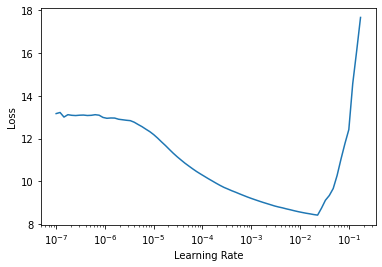

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,6.314414,5.425480,227.120422,00:14


In [ ]:
# saving the vocabulary
vocab_lm = tokenizer.save_vocabulary('./data', 'camembert_vocab')

In [ ]:
# saving the newly trained model
learn.save('1epoch')

Path('models/1epoch.pth')

## Inference

In [ ]:
df_valid.head(1)

,0,1,2
0,http://www.allocine.fr/film/fichefilm-51895/critiques/spectateurs,"Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.",0


In [ ]:
prompt = "ce film est un navet, il met en"

In [ ]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 12])

In [ ]:
preds = learn.model.generate(inp, max_length=40, num_beams=5, temperature=1.5)

In [ ]:
tokenizer.decode(preds[0].cpu().numpy())

'<s> ce film est un navet, il met en</s> scène une une scène de de guerre guerre de la fin de de la guerre guerre de la la guerre guerre de la la guerre guerre de la'

NOTE: The model 'RobertaForCausalLM' is not supported for text-generation. Supported models are ['XLNetLMHeadModel', 'TransfoXLLMHeadModel', 'ReformerModelWithLMHead', 'GPT2LMHeadModel', 'GPTNeoForCausalLM', 'OpenAIGPTLMHeadModel', 'CTRLLMHeadModel', 'TFXLNetLMHeadModel', 'TFTransfoXLLMHeadModel', 'TFGPT2LMHeadModel', 'TFOpenAIGPTLMHeadModel', 'TFCTRLLMHeadModel']